<a href="https://colab.research.google.com/github/LukeAndrewSmith/DM_Project/blob/master/DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helpers

In [ ]:
# Pretty print helpers
def print_section(title):
    print()
    print('=' * (len(title) + 4))
    print(' ', title)
    print('=' * (len(title) + 4))

def print_subsection(title):
    print('-' * (len(title) + 4))
    print(' ', title)
    print('-' * (len(title) + 4))

# Array diff
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

# Beijing

## Importing the data
We will begin by importing the csv files into pandas dataframes, a data type that can greatly simplify the process of data cleansing.

We also print out the time taken to read the csv files.

Note that we converted the Beijing_AirQuality_Stations_en.xls file to a csv, removing the unnecessary info.


In [ ]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer

# Ensure pandas outputs all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

def get_dataframe(filename):
    df = pd.read_csv(filename)
    return df

if 'aq_1' in globals():
  del aq_1
if 'aq_2' in globals():
  del aq_2
if 'meo_1' in globals():
  del meo_1
if 'meo_2' in globals():
  del meo_2
if 'meo_3' in globals():
  del meo_3
if 'aq_stations' in globals():
  del aq_stations

start = timer()
aq_1 = get_dataframe('beijing_17_18_aq.csv')
aq_2 = get_dataframe('beijing_201802_201803_aq.csv')
meo_1 = get_dataframe('beijing_17_18_meo.csv')
meo_2 = get_dataframe('beijing_201802_201803_me.csv')
meo_3 = get_dataframe('Beijing_historical_meo_grid.csv')
aq_stations = get_dataframe('Beijing_AirQuality_Stations_en.csv')
end = timer()

print_section('Time')
print(end - start)



  Time
0.8262745269998959


## Initial look at the data
We will print the heads of the **DataFrames** to get an idea of the information each csv can provided.\
We will also find the max/min times to check that the date ranges between the AQ and MEO data correspond.

In [ ]:
## AQ
print_section('beijing_17_18_aq.csv')
print_subsection('head')
print(aq_1.head(1))
print_subsection('utc_time')
print('Min:', aq_1.utc_time.min())
print('Max:', aq_1.utc_time.max())

print_section('beijing_201802_201803_aq.csv')
print_subsection('head')
print(aq_2.head(1))
print_subsection('utc_time')
print('Min:', aq_2.utc_time.min())
print('Max:', aq_2.utc_time.max())

## MEO
print_section('beijing_17_18_meo.csv')
print_subsection('head')
print(meo_1.head(1))
print_subsection('utc_time')
print('Min:', meo_1.utc_time.min())
print('Max:', meo_1.utc_time.max())

print_section('beijing_201802_201803_me.csv')
print_subsection('head')
print(meo_2.head(1))
print_subsection('utc_time')
print('Min:', meo_2.utc_time.min())
print('Max:', meo_2.utc_time.max())

print_section('Beijing_historical_meo_grid.csv')
print_subsection('head')
print(meo_3.head(1))

# Check that the features of meo_1 and meo_2 correspond
print_section('Diff meo_1 meo_2')
print_subsection('Features')
print(diff(meo_1.columns, meo_2.columns))
print(diff(meo_2.columns, meo_1.columns))


  beijing_17_18_aq.csv
--------
  head
--------
         stationId             utc_time  PM2.5   PM10    NO2   CO   O3  SO2
0  aotizhongxin_aq  2017-01-01 14:00:00  453.0  467.0  156.0  7.2  3.0  9.0
------------
  utc_time
------------
Min: 2017-01-01 14:00:00
Max: 2018-01-31 15:00:00

  beijing_201802_201803_aq.csv
--------
  head
--------
         stationId             utc_time  PM2.5  PM10   NO2   CO   O3   SO2
0  aotizhongxin_aq  2018-01-31 16:00:00   49.0  82.0  90.0  0.9  6.0  10.0
------------
  utc_time
------------
Min: 2018-01-31 16:00:00
Max: 2018-03-31 15:00:00

  beijing_17_18_meo.csv
--------
  head
--------
   station_id             utc_time  temperature  pressure  humidity  wind_direction  wind_speed      weather
0  shunyi_meo  2017-01-30 16:00:00         -1.7    1028.7      15.0           215.0         1.6  Sunny/clear
------------
  utc_time
------------
Min: 2017-01-30 16:00:00
Max: 2018-01-31 15:00:00

  beijing_201802_201803_me.csv
--------
  head
--------
    st

## Observations
Above we can see that the files
beijing_17_18_aq.csv and beijing_201802_201803_aq.csv
contain all the necessary info for the air quality and the files 
beijing_17_18_meo.csv and beijing_201802_201803_me.csv
contain all the necessary info for the meteorological data.

The file Beijing_historical_meo_grid.csv contains grid data for a smaller time period and does not correspond directly with the AQ data. \
**Decision** \
We could use the Data to help interpolate the missing values in the MEO datasets but we will not as we don't have the time.

We can also see that 
beijing_17_18_meo.csv
begins on 2017-01-30 rather than 2017-01-01 like for the AQ data sets, and so we will need to drop the first 30 days from the AQ data sets or add nans and interpolate.
**Decision** \
We will add nans and interpolate.

## Cleaning and merging the data

###Get all utc_times

In [ ]:
# Each station should have the following datetimes
# times = [2017-02-01 00:00:00, ... , 2018-03-20 23:00:00]

from datetime import timedelta, date, datetime

def daterange(date1, date2):
    for m in range(int ((date2 - date1).days)+1):
        for n in range(24):
            yield date1 + timedelta(days=m,hours=n)

#### DECISION ####
# Meo is missing 2017-01 so we discard all data from this month
start_dt = datetime(2017, 2, 1, 0, 0, 0)
end_dt = datetime(2018, 3, 22, 23, 0, 0)
ran = daterange(start_dt, end_dt)
times = [r.strftime("%Y-%m-%d %H:%M:%S") for r in ran]
print(times[0:3])
print(times[-3:])


['2017-02-01 00:00:00', '2017-02-01 01:00:00', '2017-02-01 02:00:00']
['2018-03-22 21:00:00', '2018-03-22 22:00:00', '2018-03-22 23:00:00']


### Extrapolation Function

In [ ]:
# Extrapolation
from scipy.optimize import curve_fit

# Function to curve fit to the data
def func(x, a, b, c, d):
    return a * (x ** 3) + b * (x ** 2) + c * x + d

def extrapolate(df, stringCols, verbose=False):

    dfStrings = df[stringCols]
    df = df.drop(stringCols, axis=1)

    # Initial parameter guess, just to kick off the optimization
    guess = (0.5, 0.5, 0.5, 0.5)

    # Create copy of data to remove NaNs for curve fitting
    fit_df = df.dropna()

    # Place to store function parameters for each column
    col_params = {}

    # Curve fit each column
    for col in fit_df.columns:
        # Get x & y
        x = fit_df.index.astype(float).values
        y = fit_df[col].values
        # Curve fit column and get curve parameters
        params = curve_fit(func, x, y, guess)
        # Store optimized parameters
        col_params[col] = params[0]

    # Extrapolate each column
    for col in df.columns:
        # Get the index values for NaNs in the column
        x = df[pd.isnull(df[col])].index.astype(float).values
        # Extrapolate those points with the fitted function
        df[col][x] = func(x, *col_params[col])

    if verbose:
        print ('Extrapolated data:')
        print (df)
        print ()
        print ('Data was extrapolated with these column functions:')
        for col in col_params:
            print ('f_{}(x) = {:0.3e} x^3 + {:0.3e} x^2 + {:0.4f} x + {:0.4f}'.format(col, *col_params[col]))

    for col in stringCols:
        df[col] = dfStrings[col]
    return df

###AQ fill in missing utc_time + interpolate + plot


  Missing AQ
----------------------
  Rows to add format
----------------------
[{'utc_time': '2017-02-06 15:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-06 16:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-06 20:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-06 21:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-06 23:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-07 10:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-07 11:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-07 14:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-08 05:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-08 10:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-08 15:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-08 16:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02-08 17:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-02

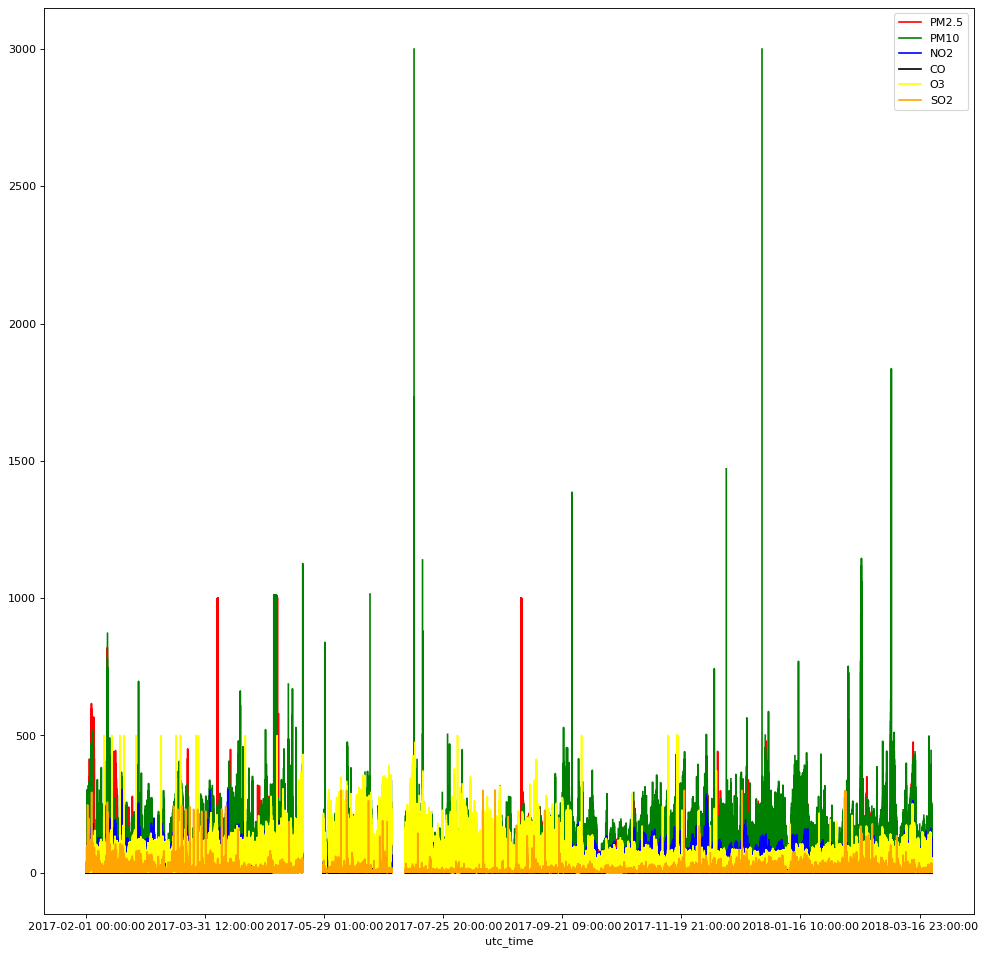

False


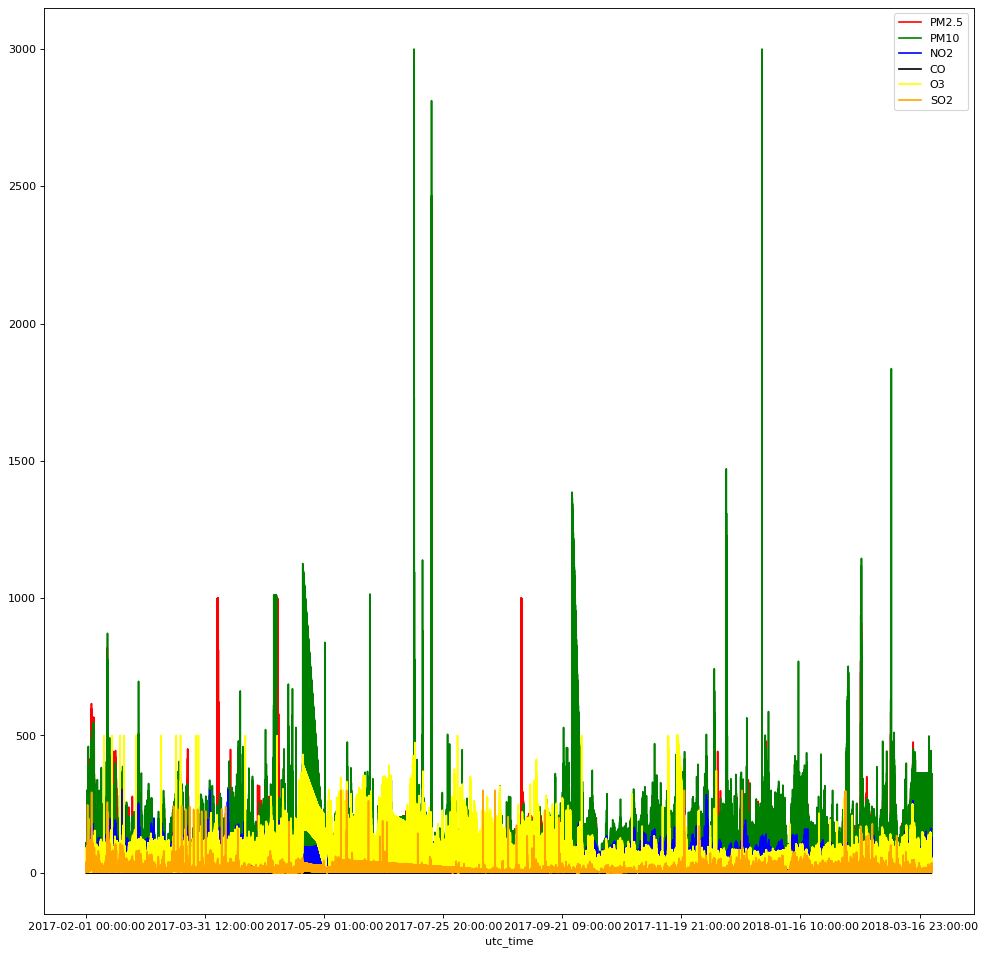

In [ ]:
# AQ Merge Tables

# Concat
aq = aq_1.append(aq_2)

#### DECISION ####
# Not all the required hours/days (utc_time's) are presents
# We will add NaNs for missing utc_time's and they will be filled in with the interpolation below
print_section('Missing AQ')
missing_aq = []
for id in aq.stationId.unique():
    dates_id = aq[aq.stationId == id].utc_time
    missing_dates_id = diff(times, dates_id)
    for date in missing_dates_id:
        missing_aq.append({'utc_time': date, 'stationId': id})

print_subsection('Rows to add format')
print(missing_aq[1:20])

print_subsection('Shapes before/after add')
print(aq.shape[0])
aq = aq.append(missing_aq, ignore_index=True)
print(aq.shape[0])

print_subsection('Verify all dates')
print('Check diff between expected times and actual for each station, should be an array of zeros')
len_check = []
for id in aq.stationId.unique():
    len_check.append(len(diff(times, aq[aq.stationId == id]['utc_time'].unique())))
print(len_check)

# Keep only the specified times
aq = aq.loc[(aq.utc_time >= times[0]) & (aq.utc_time <= times[-1])]
# Make sure stations are sorted alphabetically
aq = aq.sort_values(['utc_time', 'stationId'])

# Plots
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.gca()
aq.plot(kind='line',x='utc_time',y='PM2.5', color='red', ax=ax)
aq.plot(kind='line',x='utc_time',y='PM10', color='green', ax=ax)
aq.plot(kind='line',x='utc_time',y='NO2', color='blue', ax=ax)
aq.plot(kind='line',x='utc_time',y='CO', color='black', ax=ax)
aq.plot(kind='line',x='utc_time',y='O3', color='yellow', ax=ax)
aq.plot(kind='line',x='utc_time',y='SO2', color='orange', ax=ax)
plt.show()

#### DECISION ####
# Interpolate + Extrapolate before separating the test/train data, IS THIS WRONG?????
# Interpolate missing values by separate station
for station in aq['stationId'].unique():
    aq.loc[aq.stationId == station] = extrapolate(aq.loc[aq.stationId == station].interpolate(method='linear'),['utc_time','stationId'])

print(aq.isnull().values.any())

# Plots
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.gca()
aq.plot(kind='line',x='utc_time',y='PM2.5', color='red', ax=ax)
aq.plot(kind='line',x='utc_time',y='PM10', color='green', ax=ax)
aq.plot(kind='line',x='utc_time',y='NO2', color='blue', ax=ax)
aq.plot(kind='line',x='utc_time',y='CO', color='black', ax=ax)
aq.plot(kind='line',x='utc_time',y='O3', color='yellow', ax=ax)
aq.plot(kind='line',x='utc_time',y='SO2', color='orange', ax=ax)
plt.show()

###MEO fill in missing utc_time + interpolate + plot


  Missing MEO
----------------------
  Rows to add format
----------------------
[{'utc_time': '2018-01-08 10:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2018-01-08 11:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2018-02-07 20:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-03-27 06:00:00', 'station_id': 'hadian_meo'}, {'utc_time': '2018-01-08 09:00:00', 'station_id': 'hadian_meo'}, {'utc_time': '2018-01-08 10:00:00', 'station_id': 'hadian_meo'}, {'utc_time': '2018-01-08 11:00:00', 'station_id': 'hadian_meo'}, {'utc_time': '2018-02-07 20:00:00', 'station_id': 'hadian_meo'}, {'utc_time': '2018-01-08 09:00:00', 'station_id': 'yanqing_meo'}, {'utc_time': '2018-01-08 10:00:00', 'station_id': 'yanqing_meo'}, {'utc_time': '2018-01-08 11:00:00', 'station_id': 'yanqing_meo'}, {'utc_time': '2018-02-07 20:00:00', 'station_id': 'yanqing_meo'}, {'utc_time': '2018-01-08 09:00:00', 'station_id': 'miyun_meo'}, {'utc_time': '2018-01-08 10:00:00', 'station_id': 'miyun_meo'}, {'utc

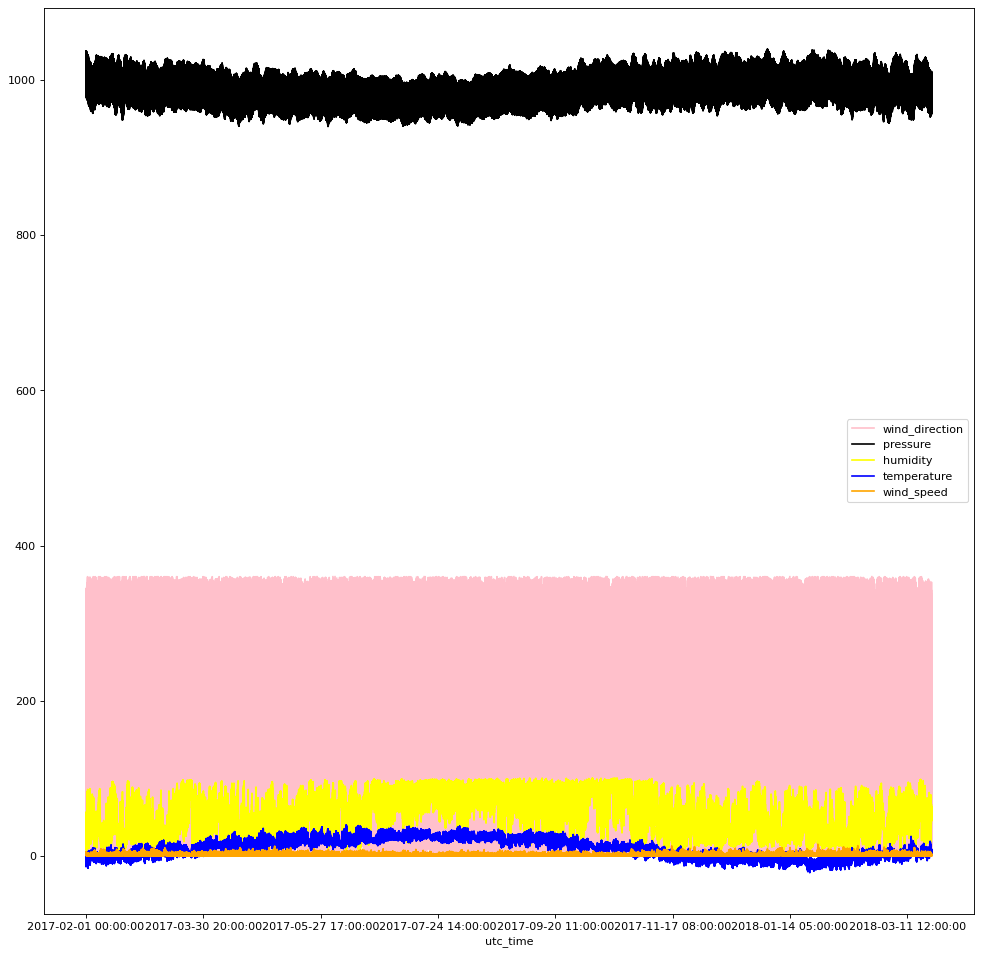

False


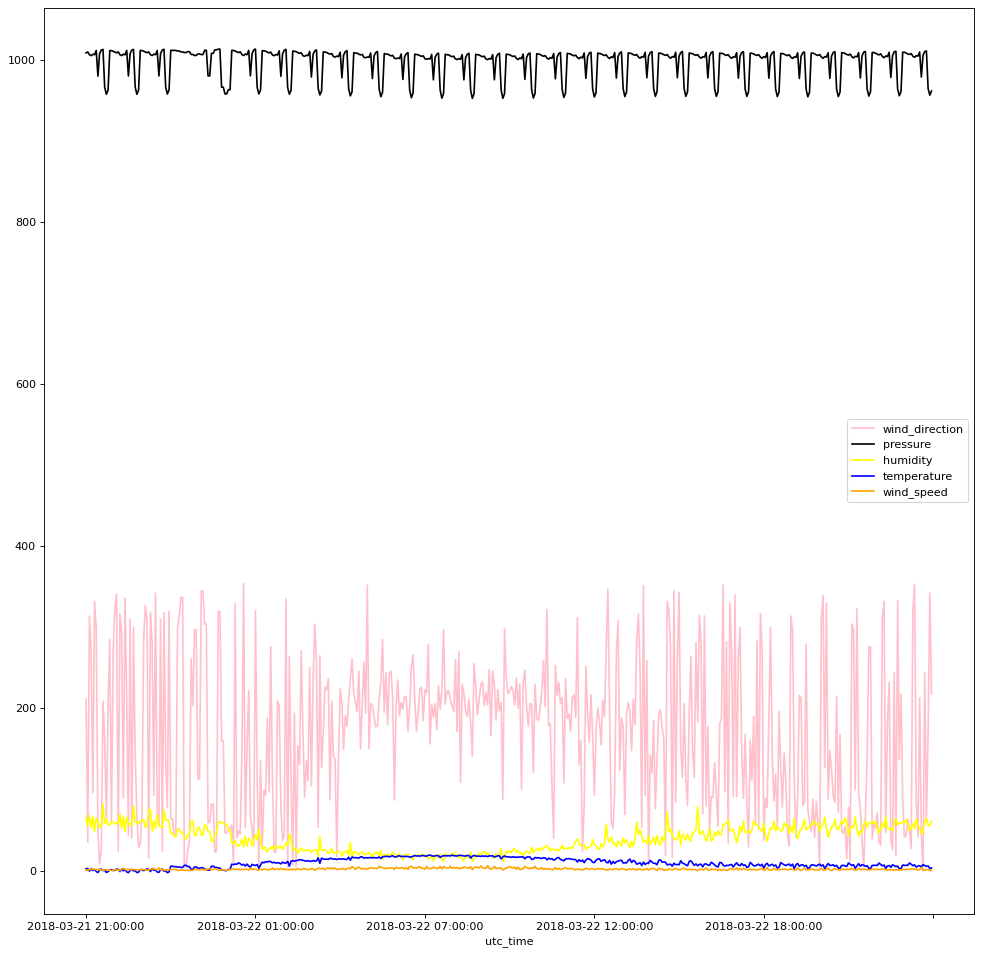

In [ ]:
#MEO MERGE

#### DECISION ####
# Replace invalid wind_direction's by nan
meo_1 = meo_1.replace(meo_1[meo_1.wind_direction > 360]['wind_direction'].unique(), np.nan)
meo_2 = meo_2.replace(meo_2[meo_2.wind_direction > 360]['wind_direction'].unique(), np.nan)

#### DECISION ####
# Replace invalid humidities's by nan
meo_1 = meo_1.replace(meo_1[meo_1.humidity > 100]['humidity'].unique(), np.nan)
meo_2 = meo_2.replace(meo_2[meo_2.humidity > 100]['humidity'].unique(), np.nan)

#### DECISION ####
# TODO: Maybe get data from grid before interpolating (need long/lat)
# Decision: Don't take data from grid, don't have time 

# Drop lat/long, would be used if we fetched data from the grid before interpolating
if 'latitude' in meo_1:
    meo_1 = meo_1.drop(['latitude', 'longitude'], axis=1) # Drop unused columns

# Concat
meo = meo_1.append(meo_2)

#### DECISION ####
# Not all the required hours/days (utc_time's) are presents
# We will add NaNs for missing utc_time's and they will be filled in with the interpolation below
print_section('Missing MEO')
missing_meo = []
for id in meo.station_id.unique():
    dates_id = meo[meo.station_id == id].utc_time
    missing_dates_id = diff(times, dates_id)
    for date in missing_dates_id:
        missing_meo.append({'utc_time': date, 'station_id': id})

print_subsection('Rows to add format')
print(missing_meo[1:20])

print_subsection('Shapes before/after add')
print_subsection
print(meo.shape[0])
meo = meo.append(missing_meo, ignore_index=True)
print(meo.shape[0])

print_subsection('Verify all dates')
print('Check diff between expected times and actual for each station, should be an array of zeros')
len_check = []
for id in meo.station_id.unique():
    len_check.append(len(diff(times, meo[meo.station_id == id]['utc_time'].unique())))
print(len_check)

# Keep only the specified times
meo = meo.loc[(meo.utc_time >= times[0]) & (meo.utc_time <= times[-1])]
# Make sure stations are sorted alphabetically
meo = meo.sort_values(['utc_time', 'station_id'])

# Plots
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.gca()
meo.plot(kind='line',x='utc_time',y='wind_direction', color='pink', ax=ax)
meo.plot(kind='line',x='utc_time',y='pressure', color='black', ax=ax)
meo.plot(kind='line',x='utc_time',y='humidity', color='yellow', ax=ax)
meo.plot(kind='line',x='utc_time',y='temperature', color='blue', ax=ax)
meo.plot(kind='line',x='utc_time',y='wind_speed', color='orange', ax=ax)
plt.show()

#### DECISION ####
# Interpolate before separating the test/train data, IS THIS WRONG?????
# TODO: Interpolate the stations separately????????????????????????
# Interpolate missing values
for station in meo['station_id'].unique():
    meo.loc[meo.station_id == station] = extrapolate(meo.loc[meo.station_id == station].interpolate(method='linear'),['utc_time','station_id', 'weather'])

print(meo.drop(['weather'],axis=1).isnull().values.any())

# Plots
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.gca()
meo.plot(kind='line',x='utc_time',y='wind_direction', color='pink', ax=ax)
meo.plot(kind='line',x='utc_time',y='pressure', color='black', ax=ax)
meo.plot(kind='line',x='utc_time',y='humidity', color='yellow', ax=ax)
meo.plot(kind='line',x='utc_time',y='temperature', color='blue', ax=ax)
meo.plot(kind='line',x='utc_time',y='wind_speed', color='orange', ax=ax)
plt.show()

###Feature Extraction

In [ ]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

###AQ+MEO Concat 

In [ ]:
# AQ concat
if not aq.index.name == 'utc_time':
    aq = aq.set_index(['utc_time'])
# Add all info for a given utc_time to one column
aq_concat = aq[aq.stationId == aq.stationId.unique()[0]]
stations = aq.stationId.unique()[1:]
for station in stations:
    aq_concat = pd.concat([aq_concat,aq[aq.stationId == station]], axis=1)
#### DECISION ####
# Remove duplicate utc_time's
# Keep values from the first index instance
aq_concat = aq_concat.loc[~aq_concat.index.duplicated(keep='first')] 
print(aq_concat.index.is_unique)
# print(aq_concat)


# MEO concat
if not meo.index.name == 'utc_time':
    meo = meo.set_index(['utc_time'])
# Add all info for a given utc_time to one column
meo_concat = meo[meo.station_id == meo.station_id.unique()[0]]
stations = meo.station_id.unique()[1:]
for station in stations:
    meo_concat = pd.concat([meo_concat,meo[meo.station_id == station]], axis=1)
#### DECISION ####
# Remove duplicate utc_time's
# Keep values from the first index instance
meo_concat = meo_concat.loc[~meo_concat.index.duplicated(keep='first')] 
print(meo_concat.index.is_unique)
# print(meo_concat)

# AQ + MEO
data = pd.concat([aq_concat,meo_concat], axis=1)
# print(data)
data.drop(['stationId', 'station_id', 'weather'], axis=1, inplace=True) # TODO: Don't drop weather, convert to numeric
print(data)




True
True
                     PM2.5   PM10    NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3   SO2  PM2.5    PM10   NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3  SO2  PM2.5    PM10   NO2   CO  \
utc_time                                                                                                                                                                                             
2017-02-01 00:00:00    7.0   11.0   25.0  0.5  58.0  12.0   14.0   46.0  13.0  0.6  62.0  21.0   11.0   32.00  17.0  0.6  65.0   5.0    6.0   25.0  32.0  0.4  41.0  7.0    4.0   11.00   3.0  0.4   
2017-02-01 01:00:00    9.0   14.0   22.0  0.4  64.0  11.0   18.0   31.0  12.0  0.7  67.0  18.0   23.0   30.25  23.0  0.9  65.0   7.0    8.0   17.0  35.0  0.4  41.0  9.0    3.0   18.00   2.0  0.3   
2017-02-01 02:00:00   10.0   12.0   11.0  0.3  79.0   6.0   12.0   20.0  10.0  0.5  72.0  16.0   27.0   28.50  24.0  0.9  79.0   7.0    6.0   16.0  23.0  0.3  54.0  7.0    4.0   23.00   2.0  0.3   


###Create Test/Train data

In [ ]:
def history(h,df):
    dfHist = df.copy()
    utc_times = df.index.values

    for i in range(1,h+1):
        shifted = np.roll(utc_times, -i)
        toConcat = df.copy().reset_index()
        toConcat.utc_time = shifted
        toConcat = toConcat.set_index('utc_time')
        dfHist = pd.concat([dfHist, toConcat], axis=1)

    dfHist.drop(dfHist.index[:h], inplace=True)   # First h values can't have h history values
    dfHist.drop(dfHist.index[-1:], inplace=True)  # Last value can't have a y value associated
    return dfHist 

# df1 = pd.DataFrame([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]], columns=['utc_time','B']).set_index('utc_time')
# print(df1)
# print(history(3,df1))

# start = timer()
# t = history(3,aq_concat)
# end = timer()
# print(t)
# print_section('Time')
# print(end - start)

def x_y_split(h,df):
    X = history(h,df)
    y = df.copy()
    y.drop(y.index[:h+1], inplace=True)
    y = y[['PM2.5', 'PM10', 'O3']] # Only predict these metrics
    return X,y

# X,y = x_y_split(3,aq_concat)
# print(diff(y.index.values, X.index.values))

def test_train_split(h,df):
    data_train = df[df.index < '2018-03-21']
    data_test = df[df.index > '2018-03-21']

    X_train,y_train = x_y_split(h,data_train)
    X_test,y_test = x_y_split(h,data_test)

    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = test_train_split(3,data)

print(X_train)


                     PM2.5       PM10   NO2   CO    O3   SO2  PM2.5  PM10   NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3   SO2  PM2.5  PM10   NO2   CO    O3  SO2  PM2.5       PM10   NO2   CO  \
2017-02-01 03:00:00    6.0   8.000000   9.0  0.3  83.0   4.0   12.0  25.0   9.0  0.5  74.0  14.0   28.0  26.75  24.0  0.8  72.0  10.0    6.0  14.0  18.0  0.4  59.0  6.0    8.0  23.000000   2.0  0.3   
2017-02-01 04:00:00    9.0  12.000000  11.0  0.4  84.0   6.0   14.0  20.0   9.0  0.5  78.0  15.0   18.0  25.00  22.0  0.8  66.0   8.0    9.0  10.0  18.0  0.4  60.0  7.0   10.0  20.750000   3.5  0.3   
2017-02-01 05:00:00   15.0  13.333333  11.0  0.4  86.0   7.0   11.0  22.0  10.0  0.5  83.0  13.0   11.0  23.25  20.0  0.7  69.0   6.0    8.0  14.0  20.0  0.4  60.0  7.0    4.0  18.500000   5.0  0.3   
2017-02-01 06:00:00    8.0  14.666667  11.0  0.4  88.0   7.0   15.0  19.0  10.0  0.5  86.0  14.0    9.0  21.50  19.0  0.6  78.0   6.0   12.0  17.0  18.0  0.4  63.0  8.0    7.0  16.250000   4.0  0.

## Model Training

### Plot Helper

In [ ]:
# Plots
import matplotlib.pyplot as plt

def plot_model_prediction(mod):
    # make a prediction set using the test set
    prediction = mod.predict(X_test)

    # Evaluate the prediction accuracy of the model
    from sklearn.metrics import mean_absolute_error, median_absolute_error
    print("The Explained Variance: %.2f" % mod.score(X_test, y_test))
    print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))
    print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))

    print(np.mean(prediction-y_test<1))

    y_prediction = y_test.copy()
    y_prediction[:] = prediction

    fig=plt.figure(figsize=(13, 13), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    y_test.plot(ax = ax, legend=None)
    # ax.legend(False)
    plt.show()

    fig=plt.figure(figsize=(13, 13), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    y_prediction.plot(ax = ax, legend=None)
    plt.show()


def plot_model_prediction_2(prediction):
    y_prediction = y_test.copy()
    y_prediction[:] = prediction

    fig=plt.figure(figsize=(13, 13), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    y_test.plot(ax = ax, legend=None)
    # ax.legend(False)
    plt.show()

    fig=plt.figure(figsize=(13, 13), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    y_prediction.plot(ax = ax, legend=None)
    plt.show()

### Dummy Classifier


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


The Explained Variance: -0.68
The Mean Absolute Error: 35.37 degrees celsius
The Median Absolute Error: 32.52 degrees celsius
PM2.5    0.931818
PM2.5    0.681818
PM2.5    1.000000
PM2.5    0.818182
PM2.5    1.000000
           ...   
O3       0.204545
O3       0.431818
O3       0.636364
O3       0.386364
O3       0.000000
Length: 105, dtype: float64


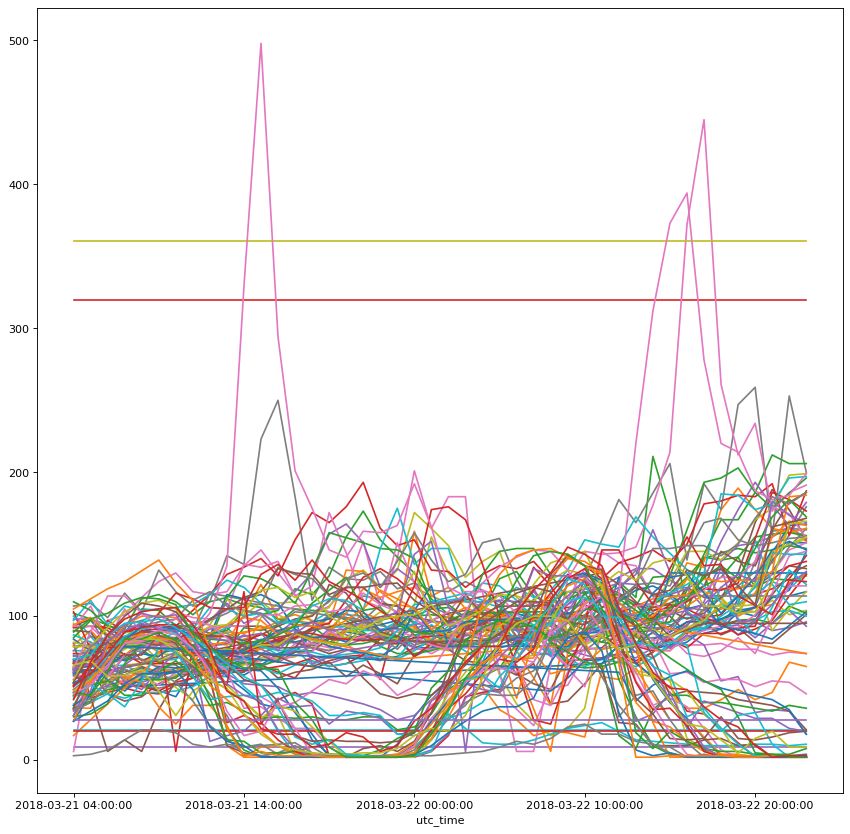

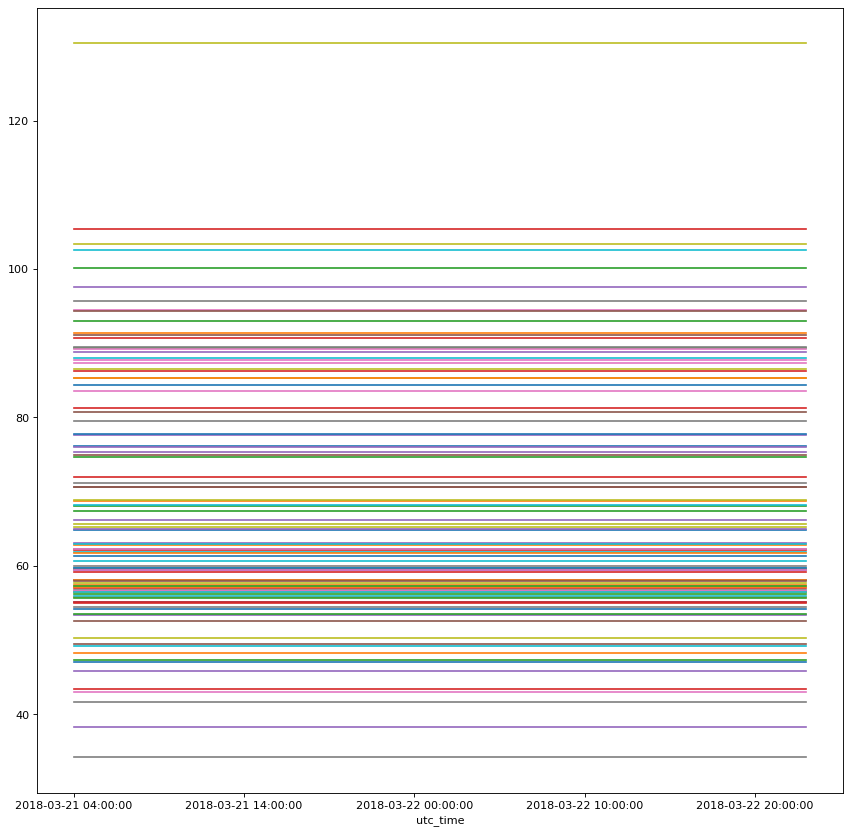

In [ ]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

plot_model_prediction(dummy_regr)

### Linear Regression

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


The Explained Variance: 0.79
The Mean Absolute Error: 8.85 degrees celsius
The Median Absolute Error: 6.75 degrees celsius
PM2.5    0.363636
PM2.5    0.295455
PM2.5    0.704545
PM2.5    0.590909
PM2.5    0.636364
           ...   
O3       0.704545
O3       0.409091
O3       0.636364
O3       0.545455
O3       0.477273
Length: 105, dtype: float64


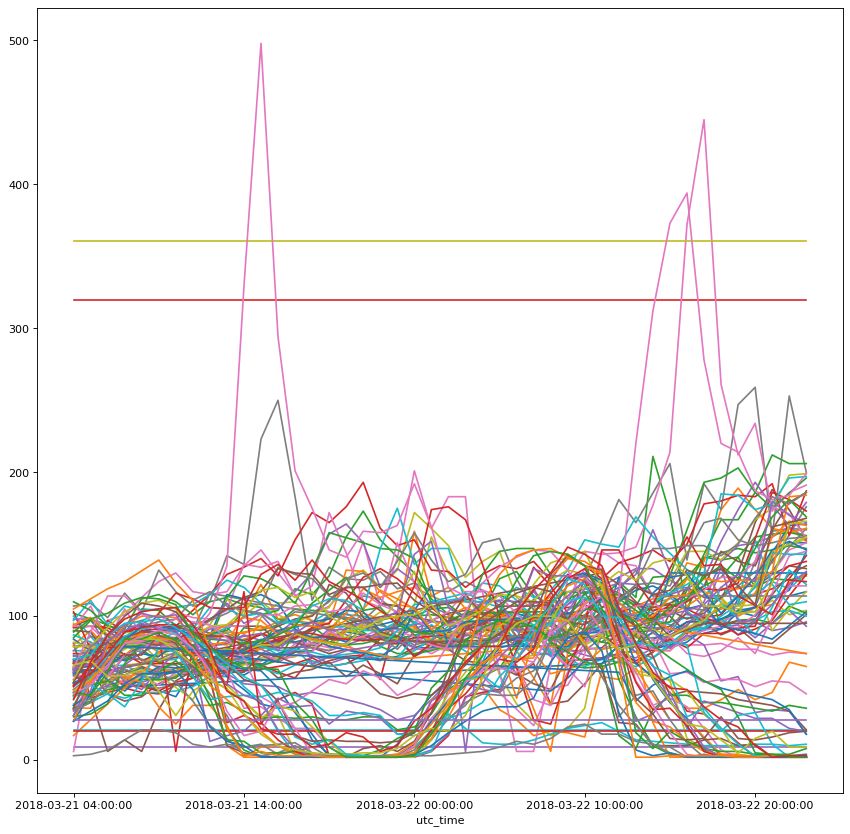

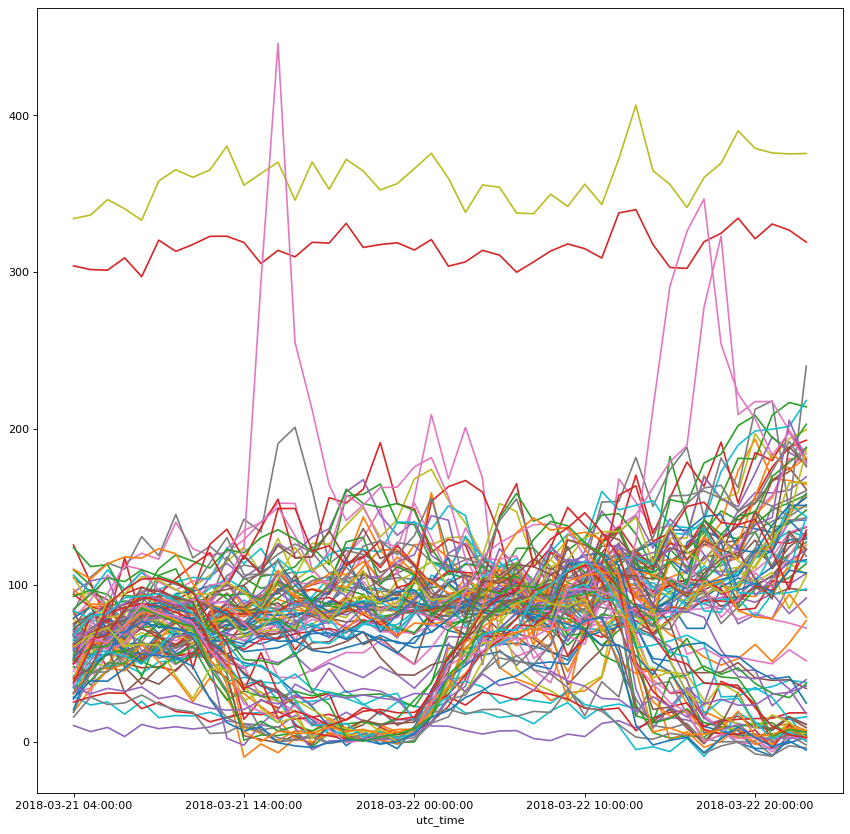

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

plot_model_prediction(reg)

### Neural Net

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

The Explained Variance: 0.61
The Mean Absolute Error: 13.14 degrees celsius
The Median Absolute Error: 10.67 degrees celsius
PM2.5    0.818182
PM2.5    0.454545
PM2.5    0.568182
PM2.5    0.295455
PM2.5    0.840909
           ...   
O3       0.545455
O3       0.477273
O3       0.795455
O3       0.659091
O3       0.500000
Length: 105, dtype: float64


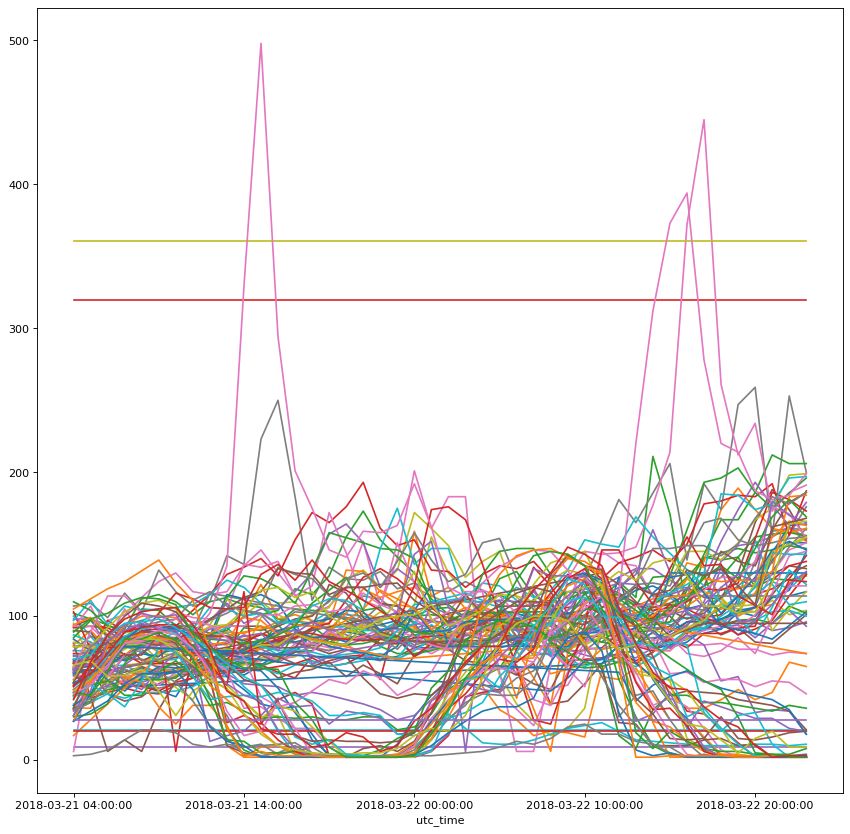

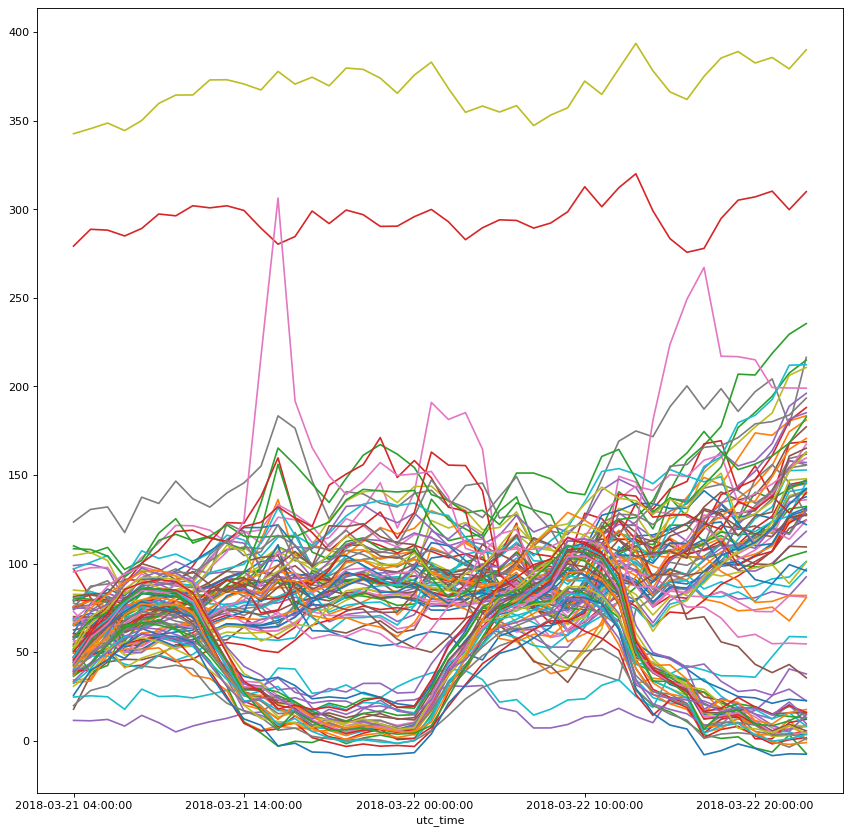

In [ ]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000)
regr.fit(X_train, y_train)

plot_model_prediction(regr)

### Random Forest Regressor

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


The Explained Variance: -0.86
The Mean Absolute Error: 38.86 degrees celsius
The Median Absolute Error: 37.60 degrees celsius
PM2.5    0.840909
PM2.5    0.659091
PM2.5    0.909091
PM2.5    0.886364
PM2.5    0.931818
           ...   
O3       0.295455
O3       0.409091
O3       0.636364
O3       0.454545
O3       0.000000
Length: 105, dtype: float64


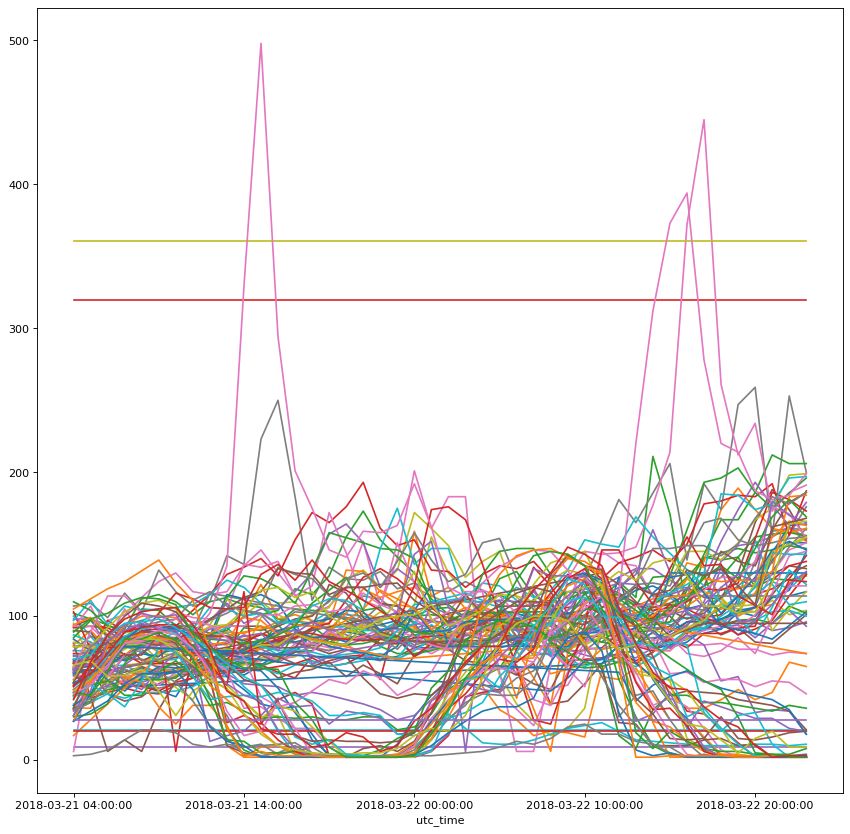

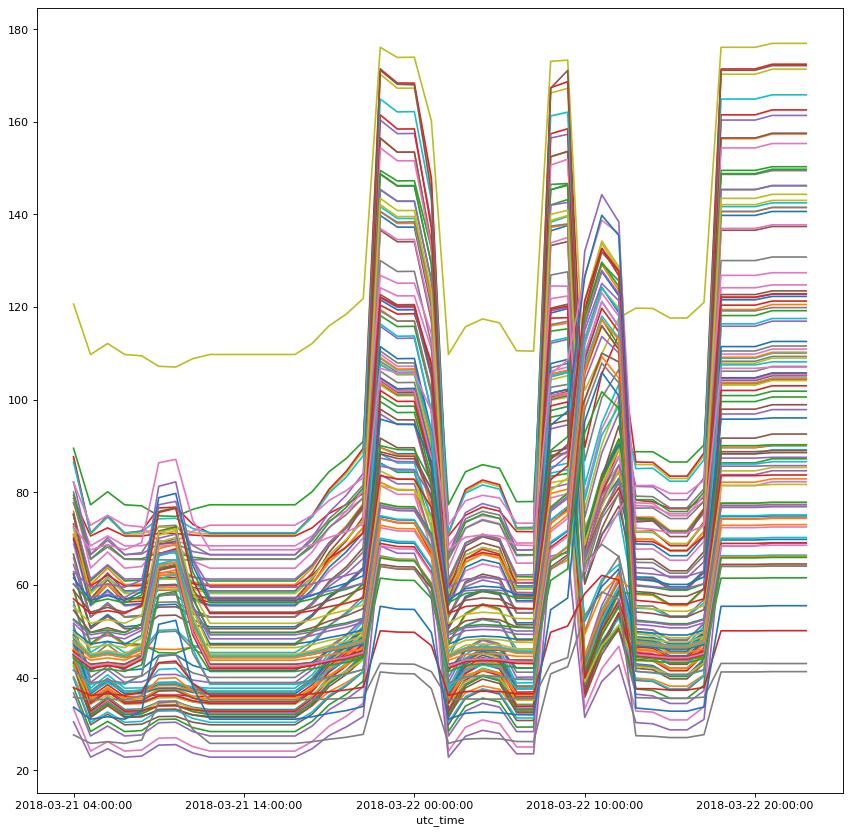

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

plot_model_prediction(regr)

### SVM

In [ ]:
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
regr = MultiOutputRegressor(svm.SVR()).fit(X_train, y_train)

plot_model_prediction(regr)

### Ridge Regression

The Explained Variance: 0.68
The Mean Absolute Error: 8.85 degrees celsius
The Median Absolute Error: 6.75 degrees celsius
PM2.5    0.363636
PM2.5    0.295455
PM2.5    0.704545
PM2.5    0.590909
PM2.5    0.636364
           ...   
O3       0.704545
O3       0.409091
O3       0.636364
O3       0.545455
O3       0.477273
Length: 105, dtype: float64


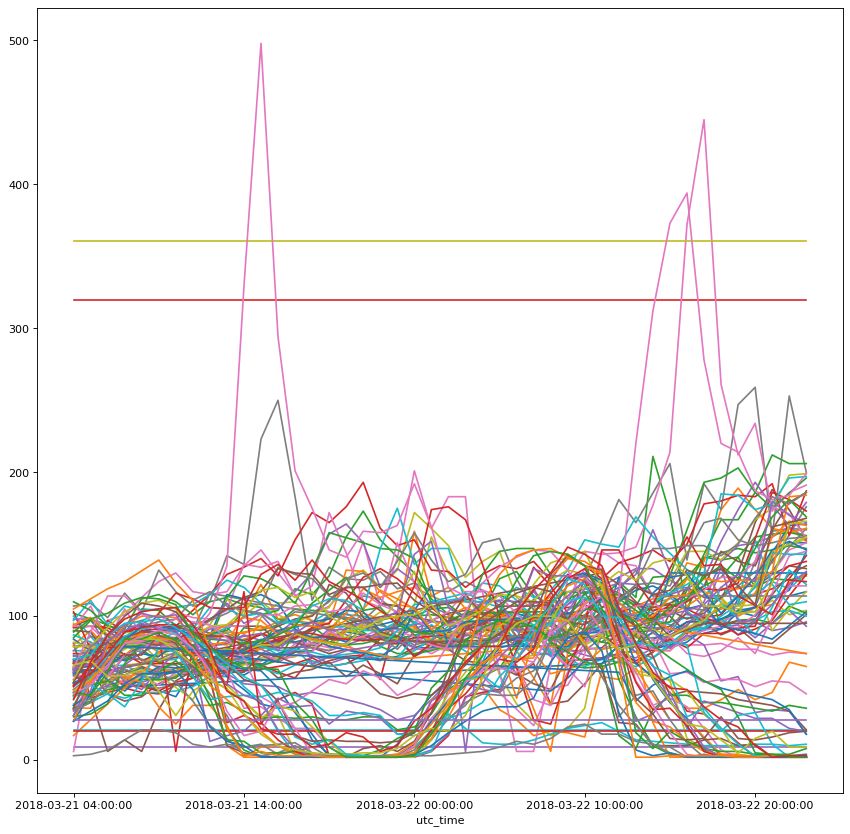

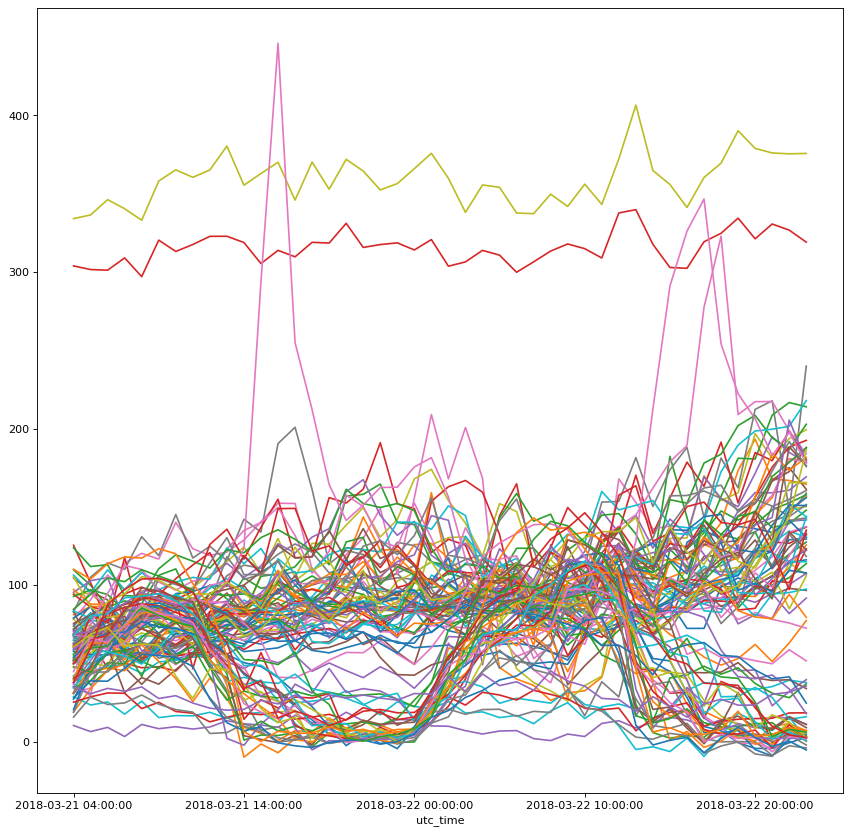

In [206]:
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
regr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train, y_train)

plot_model_prediction(regr)


### DNN Regressor

In [ ]:
import tensorflow as tf
from tensorflow.estimator import DNNRegressor

regressor = DNNRegressor( feature_columns=None, hidden_units=[10, 10] )
regressor.fit( X_train, y_train, steps=5000, batch_size=1 )


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptf0z6tw5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


AttributeError: ignored

### Gradient Boosting Regressor

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

X_train_2 = X_train.reset_index()
X_train_2 = X_train_2.drop('index',axis=1)
y_train_2 = y_train.reset_index()
y_train_2 = y_train_2.drop('utc_time',axis=1)
X_test_2 = X_test.reset_index()
X_test_2 = X_test_2.drop('index',axis=1)
y_test_2 = y_test.reset_index()
y_test_2 = y_test_2.drop('utc_time',axis=1)

feature_cols = [tf.feature_column.numeric_column(col) for col in X_train_2.columns]
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train_2,
                                               y=y_train_2,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

regressor.train(input_fn=wx_input_fn(X_train_2, y=y_train_2), steps=some_large_number)
evaluation = regressor.evaluate(input_fn=wx_input_fn(X_test_2,y_test_2,num_epochs=1,shuffle=False))
prediction = regressor.predict(input_fn=wx_input_fn(X_test_2,num_epochs=1,shuffle=False))
plot_model_prediction_2(prediction)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


ValueError: ignored

# London

## Importing the Data